In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
import fiona
import rasterio
import regionmask
warnings.filterwarnings('ignore')
import seaborn as sns
import geopandas as gpd


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [25]:
class BasinTree(object):
    def __init__(self, country, children=[], variable=[]):
        self.children: List[Tree] = children
        self.country: String = country
        self.variable: Float = variable
            
    def __repr__(self):
        return f'Tree of {self.country} with {len(self.children)} children'
    
    def is_headwaters(self):
        return len(self.children) == 0
            
    def __iter__(self):
        yield self
        for child in self.children:
            for node in child:
                yield node
                
    def is_parent(self, other):
        '''This checks "other" and returns whether it
        is a parent of the "self"'''
        all_parents = [o for o in other]
        return self in all_parents
    
    def make_comparison(self, value, metric):
        ''' Hacky way of doing this - actually will want
        to do it as an ensemble measure '''
        if value > 0.10:
            return 'Increase'
        elif value < -0.10:
            return 'Decrease'
        elif (value < 0.1) & (value > -0.1):
            return 'No Change'
            
    def compare_all_children(self, metric):
        '''Makes comparison of all children (including self)
        to see how children/parent relationships differ
        
        Returns: a matrix of child (columns; upstream) and 
        parents (rows; downstream) changes; add a tick for each
        combination of children and parents; compare the variable
        fed in when initalizing the tree
        '''
        # initalize the dataframe which will hold the analyses
        comparison_df = pd.DataFrame(np.zeros((3,3)), 
                                     columns = ['Decrease', 'No Change', 'Increase'],
                                     index = ['Increase', 'No Change', 'Decrease'])
        for upstream in self:
            for downstream in self:
                if upstream.is_parent(downstream) and upstream is not downstream:
                    try:
                        change_upstream = self.make_comparison(np.mean(upstream.variable), metric)
                        change_downstream = self.make_comparison(np.mean(downstream.variable), metric)
                            # parents (downstream) are index; children (upstream) are columns

                        comparison_df.at[change_downstream, change_upstream] += 1
                    except:
                        print('{} doesnt exist'.format(upstream.country))
        return comparison_df
    
#     def most_valid_downstream(self, metric):
#         self.compare_all_children(metric)
                    

# Initalize your river basins
#### Need to put the upstream basins in first in order to have self-referential dictionaries

In [26]:
rb = {}

# Mekong

In [27]:

rb['Mekong'] = {'outlet_country': 'Vietnam',
                'China': BasinTree('China', []),
                 'Myanmar (Burma)': BasinTree('Myanmar (Burma)', []),
                 'Thailand': BasinTree('Thailand', [])}
rb['Mekong']['Laos'] = BasinTree('Laos', [rb['Mekong']['China'], 
                                          rb['Mekong']['Myanmar (Burma)']])
rb['Mekong']['Cambodia'] = BasinTree('Cambodia', [rb['Mekong']['Laos'], 
                                                  rb['Mekong']['Thailand']])
rb['Mekong']['Vietnam'] = BasinTree('Vietnam', [rb['Mekong']['Cambodia']])


# Amazon

In [28]:
rb['Amazon'] = {'outlet_country': 'Brazil',
                'Colombia': BasinTree('Columbia', []),
                 'Ecuador': BasinTree('Ecuador', []),
                 'Bolivia': BasinTree('Bolivia', []),
             'Venezuela': BasinTree('Venezuela', []),
                 'Guyana': BasinTree('Guyana', []),
                 'French Guiana': BasinTree('French Guiana', []),}
rb['Amazon']['Peru'] = BasinTree('Peru', [rb['Amazon']['Ecuador']])
rb['Amazon']['Brazil'] = BasinTree('Amazon', [rb['Amazon'][country] for country in ['Colombia',
                                                                                   'Peru',
                                                                                   'Bolivia',
                                                                                   'Venezuela',
                                                                                   'Guyana',
                                                                                   'French Guiana']])

# Rhine

In [29]:
rb['Rhine'] = {'outlet_country': 'Netherlands',
                'Austria': BasinTree('Austria', []),
                 'Liechtenstein': BasinTree('Liechtenstein', []),
                 'France': BasinTree('France', []),
             'Luxembourg': BasinTree('Luxembourg', []),
                 'Belgium': BasinTree('Belgium', []),
                 'Italy': BasinTree('Italy', []),}
rb['Rhine']['Germany'] = BasinTree('Germany', [rb['Rhine'][country] for country in ['France',
                                                                                    'Luxembourg',
                                                                                    'Liechtenstein']])

rb['Rhine']['Netherlands'] = BasinTree('Netherlands', [rb['Rhine']['Germany']])

# Nile

In [44]:
rb['Nile'] = {'outlet_country': 'Egypt',
                'Tanzania': BasinTree('Tanzania', []),
                 'Burundi': BasinTree('Burundi', []),
                 'Eritrea': BasinTree('Eritrea', []),
             'Kenya': BasinTree('Kenya', []),
             'Ethiopia': BasinTree('Ethiopia', [])}
rb['Nile']['Rwanda'] = BasinTree('Rwanda', [rb['Nile'][country] for country in ['Burundi']])
rb['Nile']['Uganda'] = BasinTree('Sudan', [rb['Nile'][country] for country in ['Rwanda', 'Kenya', 'Tanzania']])
rb['Nile']['Sudan'] = BasinTree('Sudan', [rb['Nile'][country] for country in ['Ethiopia', 'Uganda', 'Eritrea']])

rb['Nile']['Egypt'] = BasinTree('Egypt', [rb['Nile'][country] for country in ['Sudan']])

# Columbia

In [46]:
rb['Columbia'] = {'outlet_country': 'United States',
                'Canada': BasinTree('Canada', [])}
rb['Columbia']['United States'] = BasinTree('United States', [rb['Columbia'][country] for country in ['Canada']])

# Congo

In [76]:
rb['Zaire'] = {'outlet_country': 'Zaire',
                'Cameroon': BasinTree('Cameroon', []),
              'Congo': BasinTree('Congo', []),
              'Angola': BasinTree('Angola', []),
              'Central African Republic': BasinTree('Central African Republic', []),
              'Zambia': BasinTree('Zambia', []),
              'Tanzania, United Republic of': BasinTree('Tanzania, United Republic of', [])}
rb['Zaire']['Burundi'] = BasinTree('Burundi', [rb['Zaire'][country] for country in ['Tanzania, United Republic of']])
rb['Zaire']['Rwanda'] = BasinTree('Rwanda', [rb['Zaire'][country] for country in ['Burundi']])
rb['Zaire']['Zaire'] = BasinTree('Zaire', [rb['Zaire'][country] for country in ['Rwanda', 'Angola', 'Zambia',
                                                                               'Congo', 'Central African Republic']])

# Ca - too small

# Essequibo

In [106]:
rb['Essequibo'] = {'outlet_country': 'Guyana',
                'Venezuela': BasinTree('Venezuela', []),}
rb['Essequibo']['Guyana'] = BasinTree('Guyana', [rb['Essequibo'][country] 
                                            for country in ['Venezuela']])


# Irrawaddy

In [108]:
rb['Irrawaddy'] = {'outlet_country': 'Myanmar (Burma)',
                'India': BasinTree('India', []),
                  'China': BasinTree('China', [])}
rb['Irrawaddy']['Myanmar (Burma)'] = BasinTree('Myanmar (Burma)', [rb['Irrawaddy'][country] 
                                            for country in ['India', 'China']])


# Jubba-Shebelle

In [110]:
rb['Jubba-Shebelle'] = {'outlet_country': 'Somalia',
                'Ethiopia': BasinTree('Ethiopia', []),
                  'Kenya': BasinTree('Kenya', [])}
rb['Jubba-Shebelle']['Somalia'] = BasinTree('Somalia', [rb['Jubba-Shebelle'][country] 
                                            for country in ['Ethiopia', 'Kenya']])


# Lake Chad

In [ ]:
# Don't know - weird situation with shared waterfront on endorrheic basin lake

# Lake Turkana

In [111]:
rb['Lake Turkana'] = {'outlet_country': 'Kenya',
                'Ethiopia': BasinTree('Ethiopia', [])}
rb['Lake Turkana']['Kenya'] = BasinTree('Kenya', [rb['Lake Turkana'][country] 
                                            for country in ['Ethiopia']])


# Ma - vietnam

# Maritsa

In [121]:
rb['Maritsa'] = {'outlet_country': 'Turkey',
                'Bulgaria': BasinTree('Bulgaria', [])}
rb['Maritsa']['Turkey'] = BasinTree('Turkey', [rb['Maritsa'][country] 
                                            for country in ['Bulgaria']])


# Mono - too small

# Ob

In [133]:
rb['Ob'] = {'outlet_country': 'Russia',
           'Mongolia': BasinTree('Mongolia', [])}
rb['Ob']['China'] = BasinTree('China', [rb['Ob'][country] 
                                            for country in ['Mongolia']])
rb['Ob']['Kazakhstan'] = BasinTree('Kazakhstan', [rb['Ob'][country] 
                                            for country in ['China']])
rb['Ob']['Russia'] = BasinTree('Russia', [rb['Ob'][country] 
                                            for country in ['Kazakhstan']])

# Ogooue

In [135]:
rb['Ogooue'] = {'outlet_country': 'Gabon',
           'Congo': BasinTree('Congo', []),
           'Cameroon': BasinTree('Cameroon', []),
           'Equatorial Guinea': BasinTree('Equatorial Guinea', [])}
rb['Ogooue']['Gabon'] = BasinTree('Gabon', [rb['Ogooue'][country] 
                                            for country in ['Equatorial Guinea',
                                                           'Congo',
                                                           'Cameroon']])

# Orinoco

In [137]:
rb['Orinoco'] = {'outlet_country': 'Venezuela',
           'Brazil': BasinTree('Brazil', []),
           'Colombia': BasinTree('Colombia', [])}
rb['Orinoco']['Venezuela'] = BasinTree('Venezuela', [rb['Orinoco'][country] 
                                            for country in ['Brazil', 'Colombia']])

# Song Hong

In [139]:
rb['Song Hong'] = {'outlet_country': 'Vietnam',
           'China': BasinTree('China', [])}
rb['Song Hong']['Vietnam'] = BasinTree('Vietnam', [rb['Song Hong'][country] 
                                            for country in ['China']])

# Saigon

In [141]:
rb['Saigon'] = {'outlet_country': 'Vietnam',
           'Cambodia': BasinTree('Cambodia', [])}
rb['Saigon']['Vietnam'] = BasinTree('Vietnam', [rb['Saigon'][country] 
                                            for country in ['Cambodia']])

# Salween

In [143]:
rb['Salween'] = {'outlet_country': 'Myanmar (Burma)',
           'China': BasinTree('China', []),
                'Thailand': BasinTree('Thailand', [])}
rb['Salween']['Myanmar (Burma)'] = BasinTree('Myanmar (Burma)', 
                                             [rb['Salween'][country] 
                                            for country in ['China', 'Thailand']])

# Sanaga - upstream countries too little contributing area

# San Juan

In [146]:
rb['San Juan'] = {'outlet_country': 'Costa Rica',
           'Nicaragua': BasinTree('Nicaragua', [])}
rb['San Juan']['Costa Rica'] = BasinTree('Costa Rica', 
                                             [rb['San Juan'][country] 
                                            for country in ['Nicaragua']])

# Tarim (Yarkand)

In [149]:
rb['Tarim (Yarkand)'] = {'outlet_country': 'China',
           'Kyrgyzstan': BasinTree('Kyrgyzstan', []),
            'Tajikistan': BasinTree('Tajikistan', []),
            'Pakistan': BasinTree('Pakistan', [])}
rb['Tarim (Yarkand)']['China'] = BasinTree('China', 
                                             [rb['Tarim (Yarkand)'][country] 
                                            for country in ['Kyrgyzstan',
                                                           'Tajikistan',
                                                           'Pakistan']])

# Vardar

In [151]:
rb['Vardar'] = {'outlet_country': 'Greece',
           'Serbia': BasinTree('Serbia', [])}
rb['Vardar']['Macedonia'] = BasinTree('Macedonia', 
                                             [rb['Vardar'][country] 
                                            for country in ['Serbia']])
rb['Vardar']['Greece'] = BasinTree('Greece', 
                                             [rb['Vardar'][country] 
                                            for country in ['Macedonia']])

# Ganges-Brahmabutra

In [161]:
rb['Ganges-Brahmaputra'] = {'outlet_country': 'Bangladesh',
           'China': BasinTree('China', []),
            'Bhutan': BasinTree('Bhutan', []),
            'Nepal': BasinTree('Nepal', [])}
rb['Ganges-Brahmaputra']['India'] = BasinTree('India', 
                                             [rb['Ganges-Brahmaputra'][country] 
                                            for country in ['Nepal', 'Bhutan']])
rb['Ganges-Brahmaputra']['Bangladesh'] = BasinTree('Bangladesh', 
                                             [rb['Ganges-Brahmaputra'][country] 
                                            for country in ['India']])

# Niger

In [188]:
rb['Niger'] = {'outlet_country': 'Nigeria',
           'Sierra Leone': BasinTree('Sierra Leone', []),
               'Ivory Coast': BasinTree('Ivory Coast', []),
              'Benin': BasinTree('Benin', []),
              'Burkina Faso': BasinTree('Burkina Faso', []),
              'Cameroon': BasinTree('Cameroon', []),
              'Algeria': BasinTree('Algeria', [])}
rb['Niger']['Guinea'] = BasinTree('Guinea', 
                                [rb['Niger'][country] 
                                for country in ['Sierra Leone']])
rb['Niger']['Mali'] = BasinTree('Mali', 
                                [rb['Niger'][country] 
                                for country in ['Guinea', 'Ivory Coast']])
rb['Niger']['Niger'] = BasinTree('Niger', 
                                [rb['Niger'][country] 
                                for country in ['Mali', 'Burkina Faso', 'Algeria']])
rb['Niger']['Nigeria'] = BasinTree('Nigeria', 
                                [rb['Niger'][country] 
                                for country in ['Niger', 'Benin', 'Cameroon']])

# Senegal

In [190]:
rb['Senegal'] = {'outlet_country': 'Senegal',
           'Guinea': BasinTree('Guinea', []),
            'Nepal': BasinTree('Nepal', [])}
rb['Senegal']['Mali'] = BasinTree('Mali', 
                                    [rb['Senegal'][country] 
                                    for country in ['Guinea']])
rb['Senegal']['Mauritania'] = BasinTree('Mauritania', 
                                             [rb['Senegal'][country] 
                                            for country in ['Mali']])
rb['Senegal']['Senegal'] = BasinTree('Senegal', 
                                             [rb['Senegal'][country] 
                                            for country in ['Mauritania']])

# Indus

In [196]:
rb['Indus'] = {'outlet_country': 'Pakistan',
           'China': BasinTree('China', []),
            'Afghanistan': BasinTree('Afghanistan', [])}
rb['Indus']['India'] = BasinTree('India', 
                                    [rb['Indus'][country] 
                                    for country in ['China']])
rb['Indus']['Pakistan'] = BasinTree('Pakistan', 
                                             [rb['Indus'][country] 
                                            for country in ['India', 'Afghanistan']])

# Tigris-Euphrates

In [197]:
rb['Tigris-Euphrates'] = {'outlet_country': 'Iraq',
           'Turkey': BasinTree('Turkey', []),
            'Iran': BasinTree('Iran', [])}
rb['Tigris-Euphrates']['Syria'] = BasinTree('Syria', 
                                    [rb['Tigris-Euphrates'][country] 
                                    for country in ['Turkey']])
rb['Tigris-Euphrates']['Iraq'] = BasinTree('Iraq', 
                                             [rb['Tigris-Euphrates'][country] 
                                            for country in ['Syria', 
                                                            'Iran']])

# Uruguay

In [179]:
rb['Uruguay'] = {'outlet_country': 'Uruguay',
            'Brazil': BasinTree('Brazil', [])}
rb['Uruguay']['Argentina'] = BasinTree('Argentina', 
                                             [rb['Uruguay'][country] 
                                            for country in ['Brazil']])
rb['Uruguay']['Uruguay'] = BasinTree('Uruguay', 
                                             [rb['Uruguay'][country] 
                                            for country in ['Argentina']])

# Parana

In [183]:
rb['Parana'] = {'outlet_country': 'Argentina',
            'Brazil': BasinTree('Brazil', []),
               'Bolivia': BasinTree('Bolivia', [])}
rb['Parana']['Paraguay'] = BasinTree('Paraguay', 
                                             [rb['Parana'][country] 
                                            for country in ['Brazil', 'Bolivia']])
rb['Parana']['Argentina'] = BasinTree('Argentina', 
                                             [rb['Parana'][country] 
                                            for country in ['Paraguay']])

# Zambezi

In [186]:
rb['Zambezi'] = {'outlet_country': 'Mozambique',
            'Tanzania, United Republic of': BasinTree('Tanzania, United Republic of', []),
                'Angola': BasinTree('Angola', []),
                'Botswana': BasinTree('Botswana', []),
                'Zimbabwe': BasinTree('Zimbabwe', []),
                'Namibia': BasinTree('Namibia', [])}
rb['Zambezi']['Malawi'] = BasinTree('Malawi', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Tanzania, United Republic of']])
rb['Zambezi']['Zambia'] = BasinTree('Zambia', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Angola', 'Botswana', 'Namibia']])
rb['Zambezi']['Mozambique'] = BasinTree('Mozambique', 
                                             [rb['Zambezi'][country] 
                                            for country in ['Zambia', 'Zimbabwe']])


# Danube

In [204]:
rb['Danube'] = {'outlet_country': 'Mozambique',
            'Germany': BasinTree('Germany', []),
                'Czech Republic': BasinTree('Czech Republic', []),
                'Slovakia': BasinTree('Slovakia', []),
                'Slovenia': BasinTree('Slovenia', []),
                'Montenegro': BasinTree('Montenegro', []),
                'Bosnia and Herzegovina': BasinTree('Bosnia and Herzegovina', []),
               'Bulgaria': BasinTree('Bulgaria', []), }
rb['Danube']['Austria'] = BasinTree('Austria', [rb['Danube'][country] 
                                            for country in ['Czech Republic', 
                                                            'Germany']])
rb['Danube']['Hungary'] = BasinTree('Hungary', [rb['Danube'][country] 
                                            for country in ['Austria', 
                                                            'Slovakia']])
rb['Danube']['Croatia'] = BasinTree('Croatia', 
                                             [rb['Danube'][country] 
                                            for country in ['Slovenia']])
rb['Danube']['Serbia'] = BasinTree('Serbia', [rb['Danube'][country] 
                                            for country in ['Bosnia and Herzegovina',
                                                           'Montenegro',
                                                           'Hungary']])
rb['Danube']['Romania'] = BasinTree('Romania', [rb['Danube'][country] 
                                            for country in ['Bulgaria',
                                                            'Serbia']])
rb['Danube']['Moldova'] = BasinTree('Moldova', [rb['Danube'][country] 
                                            for country in ['Romania']])
rb['Danube']['Ukraine'] = BasinTree('Ukraine', [rb['Danube'][country] 
                                            for country in ['Moldova']])

# Colorado

In [206]:
rb['Colorado'] = {'outlet_country': 'Mexico',
            'United States': BasinTree('United States', [])}
rb['Colorado']['Mexico'] = BasinTree('Mexico', 
                                             [rb['Colorado'][country] 
                                            for country in ['United States']])

In [ ]:
for river_basin in ['Paraguay']:
    for gcm in subbasins.keys():
        print(subbasins[gcm][subbasins[gcm]['NAME']==river_basin].CNTRY_NAME.values)

In [211]:
# load in your shapefiles with changes
subbasins = {}
setups = ['CSIRO-ARCCSS.ACCESS-CM2',
             'MIROC.MIROC-ES2L',
             'CCCma.CanESM5-CanOE',
             'INM.INM-CM5-0',
              'CAMS.CAMS-CSM1-0',
              'EC-Earth-Consortium.EC-Earth3-Veg',
              'INM.INM-CM4-8',
              'CSIRO-ARCCSS.ACCESS-CM2',
              'CCCma.CanESM5',
             'UA.MCM-UA-1-0',
             'NIMS-KMA.KACE-1-0-G',
             'NOAA-GFDL.GFDL-CM4',
             'CSIRO.ACCESS-ESM1-5',
             'NCAR.CESM2',
             'MRI.MRI-ESM2-0',
         'FIO-QLNM.FIO-ESM-2-0',
         'MIROC.MIROC6',
         'MPI-M.MPI-ESM1-2-LR',
         'BCC.BCC-CSM2-MR',
         'CNRM-CERFACS.CNRM-ESM2-1',
         'MOHC.UKESM1-0-LL',
         'NCAR.CESM2-WACCM',
         'CNRM-CERFACS.CNRM-CM6-1',
         'IPSL.IPSL-CM6A-LR']
for setup in setups:
    print(setup)
    subbasins[setup] = gpd.read_file('{}_ssp585_polygon_changes.shp'.format(setup))
    subbasins[setup] = subbasins[setup][~np.isnan(subbasins[setup]['mean'])]

CSIRO-ARCCSS.ACCESS-CM2
MIROC.MIROC-ES2L
CCCma.CanESM5-CanOE
INM.INM-CM5-0
CAMS.CAMS-CSM1-0
EC-Earth-Consortium.EC-Earth3-Veg
INM.INM-CM4-8
CSIRO-ARCCSS.ACCESS-CM2
CCCma.CanESM5
UA.MCM-UA-1-0
NIMS-KMA.KACE-1-0-G
NOAA-GFDL.GFDL-CM4
CSIRO.ACCESS-ESM1-5
NCAR.CESM2
MRI.MRI-ESM2-0
FIO-QLNM.FIO-ESM-2-0
MIROC.MIROC6
MPI-M.MPI-ESM1-2-LR
BCC.BCC-CSM2-MR
CNRM-CERFACS.CNRM-ESM2-1
MOHC.UKESM1-0-LL
NCAR.CESM2-WACCM
CNRM-CERFACS.CNRM-CM6-1
IPSL.IPSL-CM6A-LR


In [216]:
# take your initalized river basin and fill it with each of the 
# changes from the subbasin geopandas dataframe
river_basins = rb.keys()#['Amazon', 'Mekong', 'Rhine', 'Zaire', 'Nile', 'Columbia']
river_basin_comparison_dict = {}
for river_basin in list(rb.keys()):
    river_basin_comparison_dict[river_basin] = {}
    river_basin_comparison_dict[river_basin]['Full Ensemble'] = pd.DataFrame(np.zeros((3,3)), 
                                     columns = ['Decrease', 'No Change', 'Increase'],
                                     index = ['Increase', 'No Change', 'Decrease'])
    for setup in setups:
        i=0
        outlet_country = rb[river_basin]['outlet_country']
        for country in rb[river_basin].keys():
            if country=='outlet_country':
                continue
            try:
                rb[river_basin][country].variable = np.nan
                rb[river_basin][country].variable = subbasins[setup][(subbasins[setup]['NAME']==river_basin) & 
                                    (subbasins[setup]['CNTRY_NAME']==country)]['mean'].values[0]
                i+=1
            except:
                continue
        print('for gcm setup {} and river basin {} there were {} valid countries'.format(setup, river_basin, i))
        river_basin_comparison_dict[river_basin]['Full Ensemble'] += rb[river_basin][outlet_country].compare_all_children('mean')
          
        

for gcm setup CSIRO-ARCCSS.ACCESS-CM2 and river basin Mekong there were 5 valid countries
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
for gcm setup MIROC.MIROC-ES2L and river basin Mekong there were 4 valid countries
Cambodia doesnt exist
Laos doesnt exist
China doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Thailand doesnt exist
for gcm setup CCCma.CanESM5-CanOE and river basin Mekong there were 4 valid countries
Cambodia doesnt exist
Laos doesnt exist
China doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Thailand doesnt exist
for gcm setup INM.INM-CM5-0 and river basin Mekong there were 5 valid countries
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
Myanmar (Burma) doesnt exist
for gcm setup CAMS.CAMS-CSM1-0 and river basin Mekong there were 6 valid countries
for gcm setup EC-Earth-Consortium.EC-Earth3-Veg and river basin Meko

KeyError: 'Mozambique'

In [85]:
def heatmap_upstream_downstream(ax, df, title):
    sns.heatmap(df, ax=ax, 
            annot=True, linewidths=3, cbar=False, cmap='YlGnBu')
    ax.set_title(title, size=24)
    ax.set_xlabel('Upstream', size=16)
    ax.set_ylabel('Downstream', size=16)

In [223]:
int(3/2)

1

In [224]:
np.mod(3,2)

1

KeyError: 'Colorado'

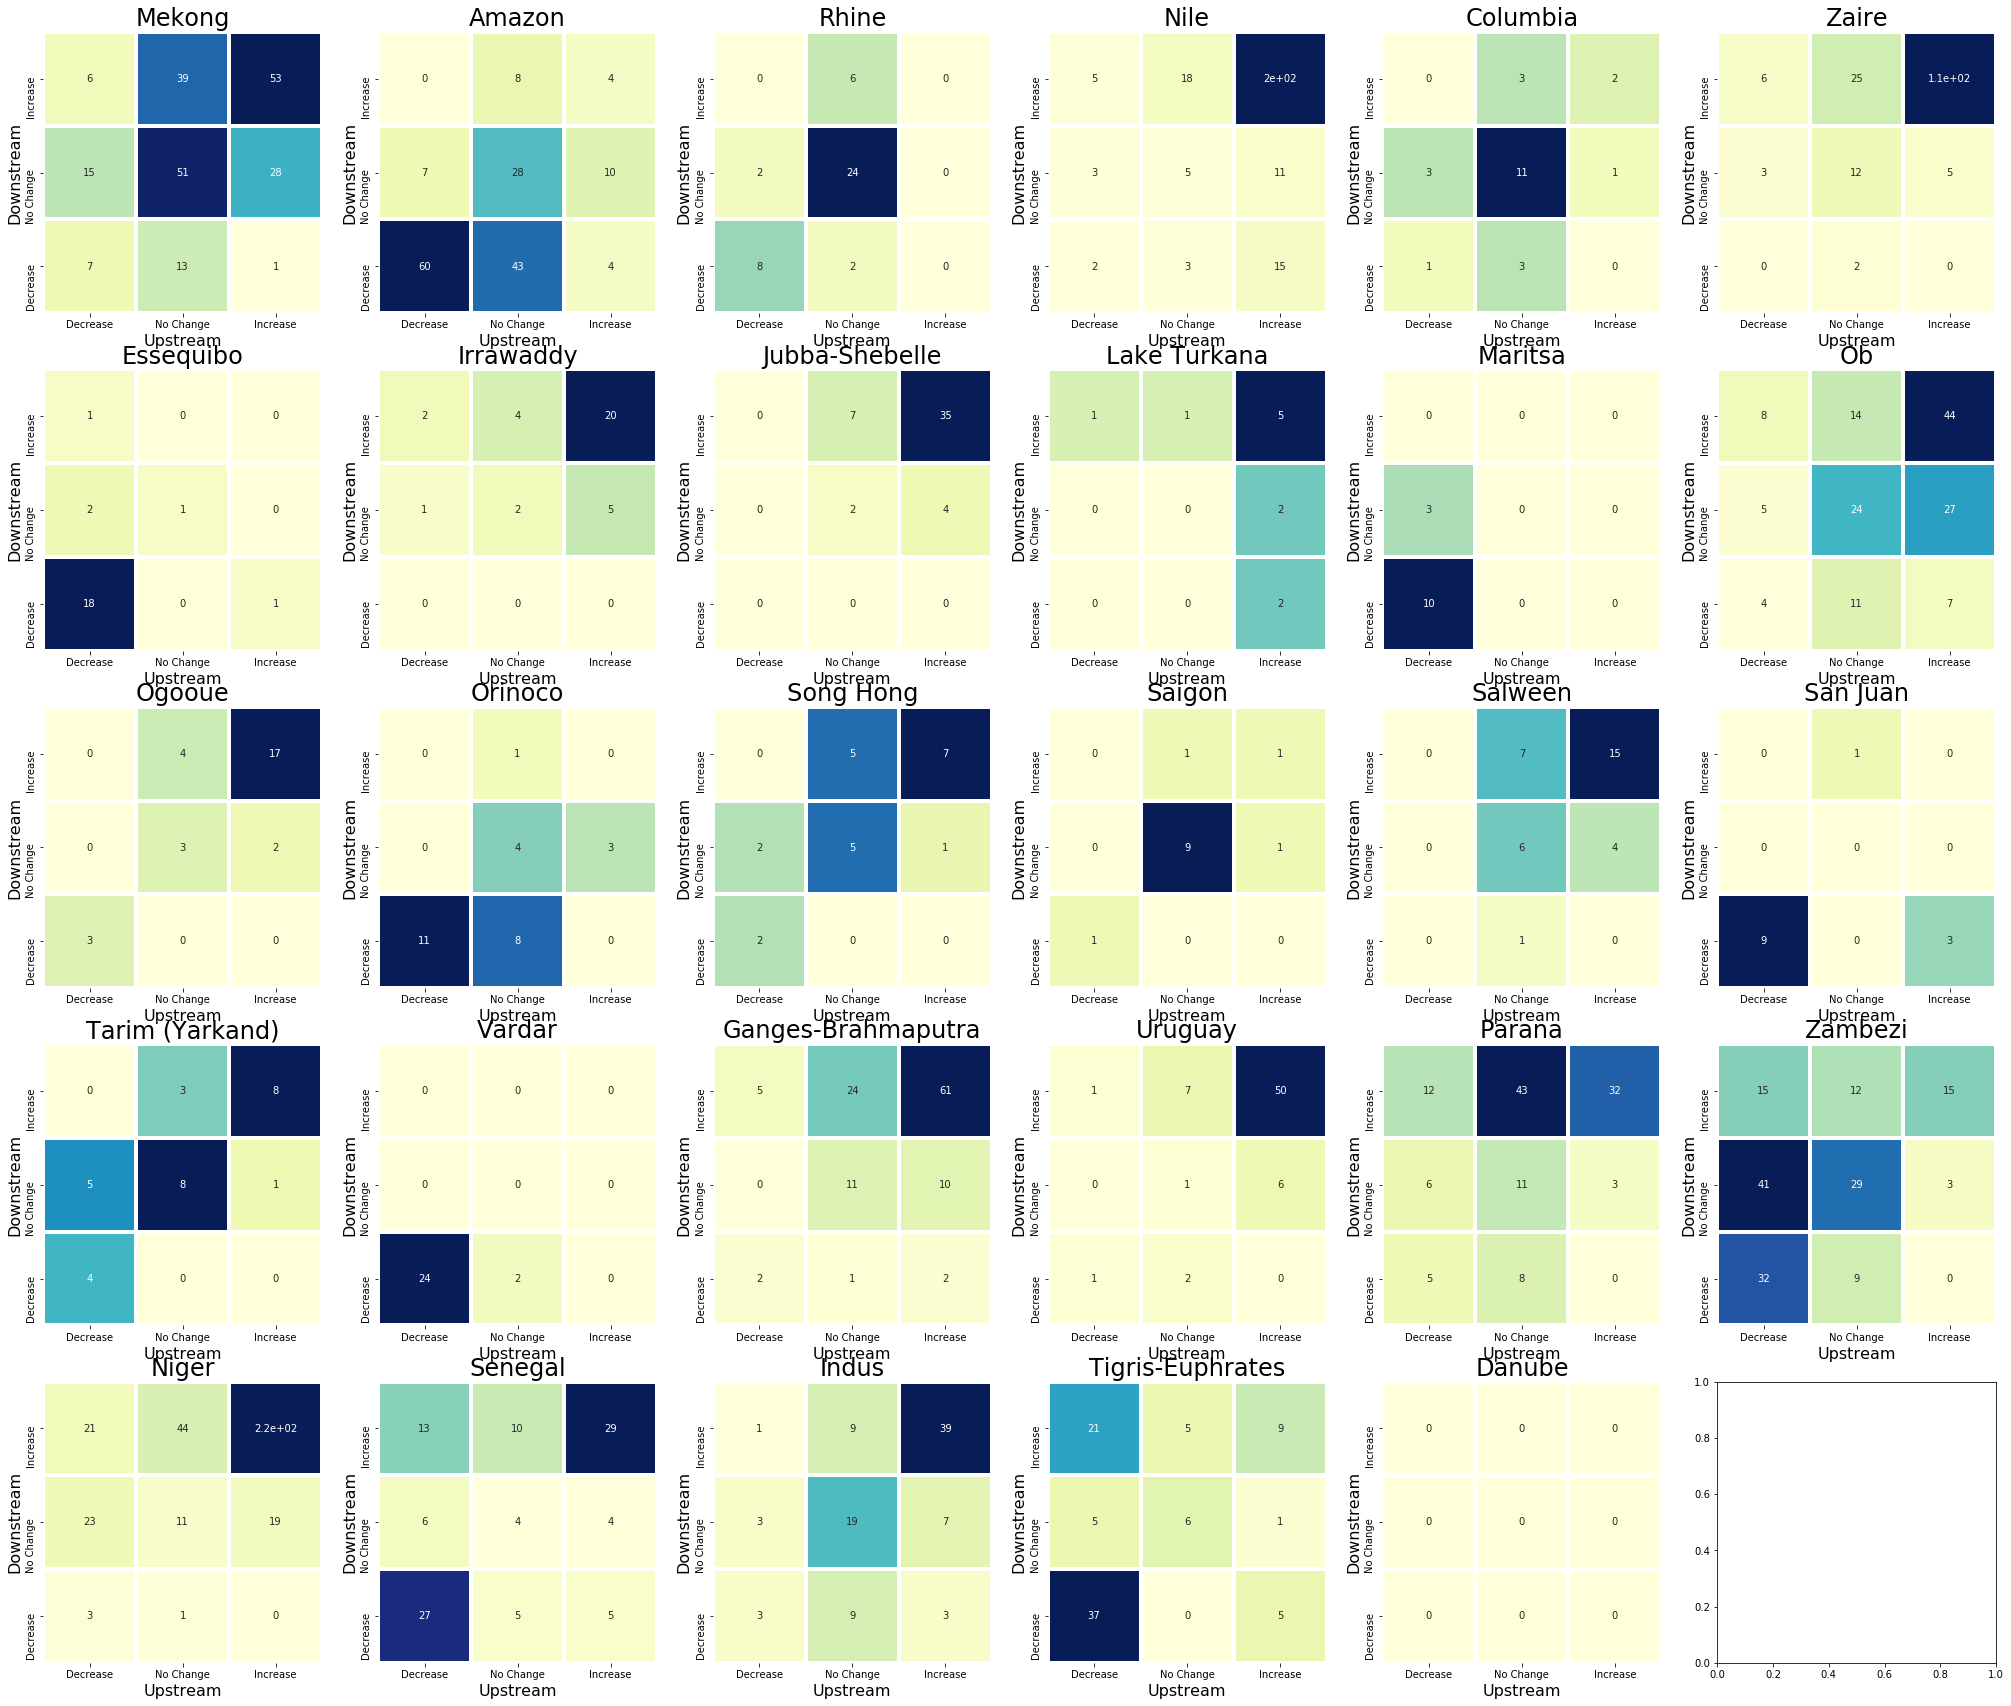

In [230]:
river_basins_toplot = list(rb.keys())
fig, axarr = plt.subplots(ncols=6, nrows=5, figsize=(35,30))

for i, river_basin in enumerate(river_basins_toplot[0:30]):
    x_location, y_location = int(i/6), np.mod(i,6)
    heatmap_upstream_downstream(axarr[x_location, y_location], 
                                river_basin_comparison_dict[river_basin]['Full Ensemble'], 
                                river_basin)
plt.tight_layout()
plt.savefig('../figures/upstream_downstream_comparisons.svg', format='svg')